<a href="https://colab.research.google.com/github/diplomado-bigdata-machinelearning-udea/Curso2/blob/master/s08/S8_C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

<h1> Diplomado de Análisis de datos y Machine Learning en Python</h1>


El presente diplomado hace parte del centro de Big Data de la facultad de ciencias exactas y naturales (FCEN) de la Universidad de Antioquia.

Empecemos por usar la versión 2 de de tensor flow:

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Intersection over Union (IOU)

La Intersección sobre unión o IOU por sus siglas en inglés determina que tan sobrepuestas están dos cajas de detección. Esto se logra dividiendo el area de intersección de dos cajas por la area total de unión de las dos cajas como se muestra en la figura:

<img src="https://www.researchgate.net/publication/335876570/figure/fig2/AS:804291526795265@1568769451765/Intersection-over-Union-IOU-calculation-diagram.png"/>

De aquí vemos que el IOU está acotado entre 0 y 1. Si la sobreposición es perfecta, la unión y la intersección son iguales, resultando en IOU=1. Por otro lado, si no se tiene sobreposición, la intersección es nula y el IOU=0.

El IOU se puede usar en 2 casos:


*   Medir que tan bueno es el ajuste al comprar la caja real con la caja predicha
*   Determinar si 2 cajas de predicción están detectando el mismo objeto

El primer caso se tiene en cuenta en la función de pérdida y el último caso se suprimen las cajas no máximas (Non-max Supression). 

In [ ]:
def cajaInter(caja1,caja2):
  xA = max(caja1[0], caja2[0]) 
  yA = max(caja1[1], caja2[1])
  xB = min(caja1[2], caja2[2])
  yB = min(caja1[3], caja2[3])
  return xA,yA,xB,yB 
def areaCaja(caja):
  return (caja[2] - caja[0] + 1) * (caja[3] - caja[1] + 1)
def IOU(caja1,caja2): #las cajas deben estar en formato [x1,y1,x2,y2]
  cajaInt=cajaInter(caja1,caja2)
  areaInt = areaCaja(cajaInt)
  area1 = areaCaja(caja1)
  area2 = areaCaja(caja2)
  iou = areaInt / (area1 + area2 - areaInt)
  return iou

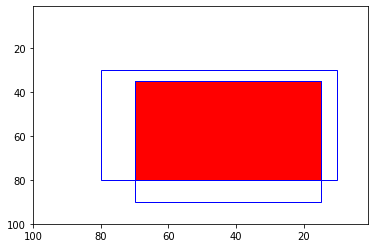

0.6161205453240851

In [ ]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
caja1=[10,30,80,80]
caja2=[15,35,70,90]
cajaInt=cajaInter(caja1,caja2)
for cajax,c in [(caja1,'none'),(caja2,'none'),(cajaInt,'r')]:
  rect = patches.Rectangle((cajax[0],cajax[1]),(cajax[2]-cajax[0]),(cajax[3]-cajax[1]),linewidth=1,edgecolor='b',facecolor=c)
  ax.add_patch(rect)
plt.ylim(100)
plt.xlim(100)
plt.show()
IOU(caja1,caja2)

## Non-max supression

Es posible que haya varias cajas detectando el mismo objeto. 

<img src="https://miro.medium.com/max/3116/1*6d_D0ySg-kOvfrzIRwHIiA.png"/>

Para evitar esta duplicidad se deben eliminar las cajas de menor confianza.
Es decir, para cada clase se revisan todas las cajas y si hay 2 o más cajas con un IOU mayor que cierto umbral, se conserva únicamente la de mayor confianza. Esto se hace de la siguiente manera para cada clase:


1.   Se descartan todas las cajas cuya confianza esté por debajo de cierto umbral.
2.   Se ordenan las cajas restantes de manera descendente por su confianza
3.   Se selecciona la caja con mayor confianza
4.   Se descartan todas las demás cajas que tengan un IOU mayor que cierto umbral




### **YOLO: You Only look Once**

Cuando tratamos con algoritmos de detección, estos pueden ser altamente costosos en términos computacionales, además de  no ser en general lo suficientemente rápidos, es por esto que se desarollaron arquitecturas como las que brinda *YOLO*, la cual fue propuesta por Joshep Redmon inicialmente en el siguiente [artículo](https://arxiv.org/pdf/1506.02640.pdf) y posteriormente mejorada en dos versiones más.

Esta arquitectura nos permite no solo hacer dectección, sino además clasificación y localización de objetos dentro de una imagen, y como su nombre lo dice, solo es necesario "ver" la imagen una sola vez; el cual tiene multiples ventajas pues podemos detectar varios objetos en una imagen de forma rápida, logrando una precisión suficiente que nos permita tener una ejecución básicamente en tiempo real, lo cual de cierta manera toma la idea que se tiene de la visión humana en la cual al ver una imagen podemos detectar inmediatamente los diferentes objetos que allí se encuentren, es por esto que esta arquitectura es bastante útil en aplicaciones como los carros autónomos.[Video](https://www.youtube.com/watch?v=MPU2HistivI)

## **¿Cómo se hace ?**


Inicialmente tenemos nuestra imagen, en la cual haremos una partición de tamaño $S\times S$, lo cual nos arrojará una rejilla de $S^{2}$ celdas, lo cual se logra básicamente haciendo un downsamplig con una arquitectura convolucional.

<p><img alt="Colaboratory logo" height="300px" src="https://miro.medium.com/max/537/1*JqNCY3zzye7_RYuE35kmsg.jpeg" align="center" hspace="10px" vspace="0px"></p>


De acuerdo a los objetos que deseamos clasificar, tendremos una asignación de estos a cierta celda, a la celda en la cual esté el centro del objeto, por lo tanto esta celda será la encargada de la detección de este objeto.  Ahora bien, por cada celda que tenemos nosotros podremos detectar *B* cajas diferentes, las cuales tendrán unos parámetros  *x*, *y*, *h*, *w*, los cuales son las coordenadas del centro de la caja y sus dimensiones, alto y ancho. Además nosotros necesitamos tener una medida que nos diga que en nuestra caja efectivamente hay o no un objeto, es por esto que se tiene un parámetro más el cual llamamos el valor de confianza (*confidence score or objectness*).


<p><img alt="Colaboratory logo" height="200px" src="https://miro.medium.com/max/928/1*b0DdaTvvr9NsoGZ2MyZL0Q.jpeg" align="center" hspace="10px" vspace="0px"></p>


Donde normalmente el valor de confianza estará dado por la medida *IOU* al hacer una comparación de las cajas predichas con las cajas reales que se tienen.


Adicionalmete a los parámetros que ya tenemos, nosotros debemos de tener unos cuantos mas de acuerdo al número de clases que buscamos clasificar en la imagen, es decir la propbabilida de que que el objeto que detectemos sea de cada clase de las cuales buscamos predecir, algo como  $P(Class_{i}|object)$. Así tendremos las siguiente salidas por cada celda:

 * B cajas
 * $P_{c}$: Confianza
 * x, y : coordenadas del centro de la caja
 * w, h : dimensiones de la caja
 * C: probabilidad de tener cierta clase

 Veremos más adelante que muchos de las arquitecturas modernas predicen parámetros en un espacio logaritmico. 


 <p><img alt="Colaboratory logo" height="400px" src="https://miro.medium.com/max/600/1*GuWOnQdxbJKWUniaiy0u1A.png" align="center" hspace="150px" vspace="0px"></p>


 Por lo tanto nuestro modelo arrojará un tensor de dimensiones $S\times S \times B(5+C)$. Donde se tendrá una arquitectura aproximadamente como la siguiente, la cual nos permitirá obtener este tipo de salidas.

  <p><img alt="Colaboratory logo" height="300px" src="https://miro.medium.com/max/678/1*sCG9Ko6bnYmV-HAy4NnYTA.png" align="center" hspace="10px" vspace="0px"></p>

Como se mencionó previamente nosotros podemos tener multiples cajas por celda, esto hará que tengamos en algunos casos multiples cajas detectando el mismo objeto, lo cual nosotros no deseamos, necesitamos aquella que mejor realice su trabajo.

  <p><img alt="Colaboratory logo" height="300px" src="https://i.imgur.com/6swht2T.png" align="center" hspace="10px" vspace="0px"></p>

Para obtener la caja que mejor confianza tenga usamos el proceso de non-max supression, el cual visto anteriormente.Veamos la función de perdida que usaremos para entrenear nuestro modelo.

# Función de Pérdida

La función de pérdida de YOLO tiene 3 componentes:


*   Coordenadas: La ubicación y tamaño de la caja
*   Clasificación: La categoría del objeto
*   Confianza: La certeza de tener un objeto





## Coordenadas

Esta componente es una función de pérdida MSE para la ubicación ($\hat{x}$,$\hat{y}$) y tamaño de la caja ($\hat{h}$,$\hat{w}$).

$$
L_{coord}=\lambda_{coord}\sum_{i=1}^{S^2}\sum_{j=1}^B \mathbb{1}_{ij} \left[(x_i-\hat{x}_i)^2+(y_i-\hat{y}_i)^2+\left(\sqrt{w_i}-\sqrt{\hat{w}_i}\right)^2+\left(\sqrt{h_i}-\sqrt{\hat{h}_i}\right)^2\right]
$$

La primera sumatoria es en el número de celdas y la segunda es en el número de cajas de cada celda. Además, el $\mathbb{1}_{ij}$ nos dice si la caja es o no la encargada de detectar el objeto.

La primera parte es la encargada de optimizar la ubicación de la caja ($\hat{x}$,$\hat{y}$) y la segunda se encarga de optimizar el tamaño. 

Vemos que la segunda parte tiene raices cuadradas. Estas raices permiten no castigar tanto pequeñas diferencias de tamaño cuando las cajas son grandes. Es decir, un error de 5 pixeles en una caja pequeña es peor que en una caja grande.

Por lo general, la red intenta no intenta optimizar directamente $x$, $y$, $w$ y $h$, en vez de esto optimiza $t_x$, $t_y$, $t_w$, $t_h$, con:

$$
x=\sigma(t_x)+c_x
$$
$$
y=\sigma(t_y)+c_y
$$
$$
w=p_w e^{t_w}
$$
$$
h=p_h e^{t_h}
$$
Dónde $p_w$ y $p_h$ son las dimensiones de cajas determinadas a priori y $c_x$ y $c_y$ determinan la ubicación de cada celda. Por ejemplo:

<img src="https://miro.medium.com/max/1310/1*91I8plGuORK1OZkSZgAjSA.png"/>

Se escogen diferentes cajas a priori con diferentes relaciones de aspecto dependiendo del dataset.

## Clasificación

La pérdida de clasificación determina si el objeto detectado pertence realmente a la categoría predica.

$$
L_{class}=\sum_{i=1}^{S^2}\mathbb{1}_{i}\sum_{c=1}^K [p(c)-\hat{p}(c)]^2
$$

Donde $\mathbb{1}_i$ determina si hay un objeto en la celda $i$. También se puede usar la entropía cruzada categórica

$$
L_{class}=-\sum_{i=1}^{S^2}\mathbb{1}_{i}\sum_{c=1}^K y_c log[\hat{p}(c)]
$$



## Confianza

La pérdida de confianza permite determinar si se detecta un objeto en la caja con el fin de evitar que el modelo detecte el fondo de la imagen.

$$
L_{conf}=\sum_{i=1}^{S^2}\sum_{c=1}^K \mathbb{1}_{ij}^{obj}\left(C_i-\hat{C}_i\right)^2+\lambda_{no-obj}\sum_{i=1}^{S^2}\sum_{c=1}^K \mathbb{1}_{ij}^{no-obj}\left(C_i-\hat{C}_i\right)^2
$$

Donde $\hat{C}_i$ es el IOU entre la caja real y la caja predicha.
El segundo término es el responsable de castigar el modelo si no hay objetos dentro de la caja. Sin embargo, la mayoría de las cajas no tendrán objetos, por lo que puede haber unas clases desbalanceadas y se incluye $\lambda_{no-obj}$ para combatirlo. En la versión 3 de YOLO esta pérdida también se toma como una Entropía Cruzada Binaria.

## **Anchor Box**

Una de las mejorías que se tuvo en los avances en las arquitecturas de *YOLO*, fue el implementar lo que se denomina **anchor box**, lo cual es básicamente definir ciertas dimensiones de cajas a priori, sobre las cuales luego se hara la predicción relativa de las coordenadas de nuestras cajas de detección, esto evitará posibles inestabilidades a la hora de entrenar, la cuales pueden ser  producto de buscar predecir dimensiones de cajas arbitrarias. Esta idea tiene bastante sentido pues en general los diferentes clases de objetos van a conservar cierta dimensión aparente en las imagenes, siempre que pertenezcan a la misma clase. Por ejemplo podríamos definir cinco **anchor box** para cierto modelo con las siguientes formas:

  <p><img alt="Colaboratory logo" height="300px" src="https://miro.medium.com/max/798/1*m0t4vdu4LH2bKYu1zQp2dA.png" align="center" hspace="10px" vspace="0px"></p>


Y sobre estas comparar nuestras predicciones relativas. Ahora bien, para definir el número de cajas apriori podemos correr un algoritmo de k-means clustering, el cual con base a las dimensiones de las cajas reales encontrará ciertas agrupaciones que nos darán unos valores medios para las **anchor box**.

  <p><img alt="Colaboratory logo" height="300px" src="https://miro.medium.com/max/606/1*BYoRZmABsiYYELjedraKYw.png" align="center" hspace="10px" vspace="0px"></p>

Para definir el número de clusters simplemente se corre el algoritmo k-means para varios valores de k y a su vez se grafica el valor promedio de la intersección sobre unión de las cajas, así podremos obtener el caso que más nos beneficie.

## Links de interés

[Link1](https://medium.com/@amrokamal_47691/yolo-yolov2-and-yolov3-all-you-want-to-know-7e3e92dc4899)

[Link2](https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088)

[Link3](https://mc.ai/dive-really-deep-into-yolo-v3-a-beginners-guide/)

[Link4](https://medium.com/analytics-vidhya/yolo-v3-theory-explained-33100f6d193)

## **You Only Look Once (YOLO) Resumen:**

Como hemos visto, la detección de objetos en visión computacional representa la tarea de identificar la presencia, localización y tipo de uno o mas objetos dentro de una fotografía (o video) dada. Consiste en un problema que involucra los siguientes tópicos:

 - Reconocimiento de objetos, para saberdónde están.
 - Localización de objetos, para saber cuál es su extensión.
 - Clasificación de objetos, para predecir la clase correcta del objeto.

La familia de modelos "You Only Look Once" (YOLO), es una serie de modelos de aprendizaje profundo diseñados parar la detección rápida y precisa de objetos, propuesto por Joseph Redmon et al. en un artículo publicado en 2015 [link al artículo](https://github.com/diplomado-bigdata-machinelearning-udea/Curso2/blob/master/s08/yolo_paper.pdf). Posteriormente, YOLO fue actualizado en 2016 ([YOLOv2](https://github.com/diplomado-bigdata-machinelearning-udea/Curso2/blob/master/s08/YOLOv2.pdf)) y en 2018 ([YOLOv3](https://github.com/diplomado-bigdata-machinelearning-udea/Curso2/blob/master/s08/YOLOv3.pdf)). A continuacion veremos la arquitectura establecida en YOLOv3:


- En primer lugar, se generan 5 cuadros delimitadores para cada celda de la cuadrícula, cada uno con un puntaje de objetividad; también ser generan 20 probabilidades de clase por celda de cuadrícula, ya que fue entrenado con el conjunto de datos PASCAL VOC (inicialmente), que contiene 20 clases, para un total de 45 números por celda de cuadrícula ($5\times4$ coordenadas del cuadro delimitador, más 5 puntajes de objetividad, más 20 probabilidades de clase).

- En segundo lugar, en lugar de predecir las coordenadas absolutas de los centros del cuadro delimitador, YOLOv3 predice un desplazamiento relativo a las coordenadas de la celda de la cuadrícula, donde (0, 0) significa la parte superior izquierda de esa celda y (1, 1) significa la parte inferior derecha. Para cada celda de la cuadrícula, YOLOv3 está capacitado para predecir solo cuadros delimitadores cuyo centro se encuentra en esa celda (pero el cuadro delimitador generalmente se extiende más allá de la celda de la cuadrícula). En YOLOv3 se aplica una función de activación logística a las coordenadas del cuadro delimitador para garantizar que permanezcan en el rango de 0 a 1.

- En tercer lugar, antes de entrenar la red neuronal, en YOLOv3 se determinan 5 dimensiones del cuadro delimitador, llamados cuadros de anclaje (o cuadros delimitadores a priori): En este paso se aplica el algoritmo de K-means sobre la altura y el ancho de llos cuadros delimitadores del conjunto de entrenamiento. Por ejemplo, si las imágenes de entrenamiento contienen muchos peatones, entonces una de las cajas de anclaje probablemente tendrá las dimensiones de un peatón típico. Luego, cuando la red neuronal predice 5 cuadros delimitadores por celda de cuadrícula, en realidad predice el factor de rescalado de cada uno de los cuadros de anclaje. Para ser más precisos, para cada celda de la cuadrícula y cada cuadro de anclaje, la red predice el registro de los factores de reescalado vertical y horizontal. Estos antecedentes hace que la red sea más propensa a predecir cuadros delimitadores de dimensiones apropiadas, y también acelera el enrenamiendo, ya que aprenderá más rápidamente cómo lucen los cuadros delimitadores que son razonables.

- En cuarto lugar, la red se entrena utilizando imágenes de diferentes escalas: cada pocos lotes durante el entrenamiento, dentro de la red se elige aleatoriamente una nueva dimensión de imagen (de $330\times330$ a $608\times608$ píxeles). Esto permite que la red aprenda a detectar objetos a diferentes escalas. Además, hace posible usar YOLOv3 a diferentes escalas: la escala más pequeña será menos precisa pero más rápida que la escala más grande, por lo que puede elegir la compensación adecuada para su caso de uso.

###**Implementación de YOLOv3 en KERAS**

La implimentación original de YOLO se encuentra desarrollada en C y puede consultarse en este [link](https://github.com/pjreddie/darknet). Este código es dificil de implementar desde cero, y require la implementación adicional de código para destilar e interpretar los delimitadores o cajas predichas por el modelo. 

En lugar de desarrollar este código desde el principio, usaremos una implementación ya hecha de YOLOv3 en Python. Cabe resaltar que existen varias implementaciones de YOLO en `keras`, no obstante, ninguna ha sido estandarizada y diseñada para usarse como una biblioteca.

Tal vez, el módelo pre-entrenado más utilizado en `keras` de YOLO es el modelo conocido como [keras-yolo3: Training and Detecting Objects with YOLO3](https://github.com/experiencor/keras-yolo3) desarrollado por  Huynh Ngoc Anh o experiencor.

###**Detección de objetos con YOLOv3 en KERAS**

La implementación [keras-yolo3](https://github.com/experiencor/keras-yolo3) proporciona varias utilidades como:

- Detección de objetos.
- Transferencia de conocimiento.
- Entrenamiento de nuevos modelos desde cero.

Dentro de este proyecto se tiene el archivo de implementación de YOLOv3 [yolo3_one_file_to_detect_them_all.py](https://raw.githubusercontent.com/experiencor/keras-yolo3/master/yolo3_one_file_to_detect_them_all.py).

En el siguiente ejemplo, usaremos parte del código del proyecto, en lugar de usarlo de forma completa, sobre un modelo preentrenado para la identificación de objetos sobre una imagen nueva.


####**Paso 1: Carga de los pesos del modelo**


In [ ]:
!curl -O https://pjreddie.com/media/files/yolov3.weights

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  236M  100  236M    0     0  15.2M      0  0:00:15  0:00:15 --:--:-- 16.7M


In [ ]:
# Selección del la versión 1 de tensorflow
%tensorflow_version 1.x

###**Paso 2:**

En el este paso realizaremos las siguientes definiciones:

- Definición de una clase para la lectura del archivo de los pesos: Esta clase es necesaria ya que los pesos fueron guardados en un formato que desconocemos, definido por `DarkNet`.  Usaremos la clase `WeightReader` para tal proposito.

- Definición de una función para la definición de un bloque de convolución.

- Definición de la arquitectura YOLOv3.

In [ ]:
from tensorflow import keras
import argparse
import os
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, concatenate, add
#from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
import cv2

keras.backend.clear_session()

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

###**Paso 3: definición del modelo**

In [ ]:
# define the model
model = make_yolov3_model()

In [ ]:
model.summary()

###**Paso 4:**

El paso 4 consta de dos etapas:

- Carga de los pesos del modelo mediaten la clase `WeightReader`.
- Configuraciónde los pesos en el modelo definido mediante el método `load_weights`.

In [ ]:
# load the model weights
weight_reader = WeightReader('yolov3.weights')

In [ ]:
# set the model weights into the model
weight_reader.load_weights(model)

In [ ]:
ls -sh

total 237M
4.0K sample_data/  237M yolov3.weights


In [ ]:
!ls correct_yolo_boxes 

ls: cannot access 'correct_yolo_boxes': No such file or directory


###**Paso 5: Almacenamiento del modelo creado**

In [ ]:
# Almacenamiento del modelo y los pesos
model.save('model.h5')

In [ ]:
#Guarda solo los pesos
model.save_weights('pesos.h5')

In [ ]:
from keras.models import load_model

In [ ]:
ls -sh

total 711M
238M model.h5  238M pesos.h5  4.0K sample_data/  237M yolov3.weights


In [ ]:
modelo=load_model('model.h5') #Carga modelo y pesos

In [ ]:
modelo.load_weights("pesos.h5") #Carga solo los pesos

**Nota:** Si por algun motivo les sale el siguiente error en la celda anterior:



```
ValueError: Fetch argument <tf.Variable 'conv_0/kernel:0' shape=(3, 3, 3, 32) dtype=float32_ref> cannot be interpreted as a Tensor. (Tensor Tensor("conv_0/kernel:0", shape=(3, 3, 3, 32), dtype=float32_ref) is not an element of this graph.)
```

Deben reiniciar el `runtime` y ejecutar volver a ejecutar desde la celda donde se selecciona `tensorflow_version 1`.


###**Paso 6: descarga de una imagen para identificación de objetos**

En este paso descargaramos una imagen de tres cebras para ser identificadas mediante cajas. 

**Nota:** Los objetos que se pueden indentificar con este modelo corresponde al dataset [MSCOCO](http://cocodataset.org/).

In [ ]:
#!curl -O https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/zebra.jpg
!curl -O https://i.imgur.com/w25DvzT.jpeg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  235k  100  235k    0     0   174k      0  0:00:01  0:00:01 --:--:--  174k


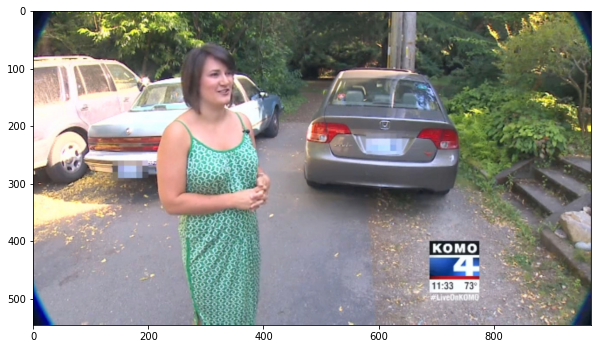

In [ ]:
import matplotlib.pyplot as plt
import cv2 

img1 = cv2.imread(r"w25DvzT.jpeg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) #Porque OpenCV carga en BGR
plt.figure(figsize=(10,10))
plt.imshow(img1)

###**Paso 7: Ilustración de la clasificación mediante YOLO**



In [ ]:
# load yolov3 model and perform object detection
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.utils import load_img , img_to_array

#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

In [ ]:
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

In [ ]:
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

In [ ]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

In [ ]:
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

In [ ]:
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

In [ ]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

In [ ]:
# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'w25DvzT.jpeg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

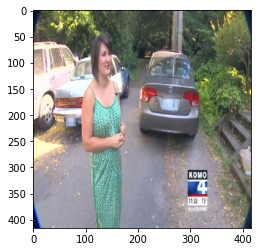

In [ ]:
plt.imshow(image[0])

In [ ]:
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

1/1 [==============================] - 1s 928ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [ ]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
len(labels)

80

In [ ]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()

In [ ]:
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

In [ ]:
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [ ]:
# suppress non-maximal boxes
do_nms(boxes, 0.5)

car 89.18346762657166
car 99.6468722820282
person 99.90063905715942
car 94.00498270988464


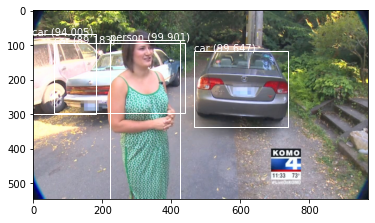

In [ ]:
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

# Ejercicio 

Apartir el ejemplo visto , implementar el modelo yolov3 para realizar deteccion en alguna figura que usted quiera (puede usar las figuras que se encuntran en la carpeta). En este [link](https://drive.google.com/open?id=1F1rxaSia2nfWGE1pWizfyHhm4ejREwoj) se encuntra un archivo llamado yolov3.py el cual contiene todas las funciones anteriormente vistas , importelo para hacer el trabajo mas facil. 

## Solucion 

Primero importemos google drive y accedamos a la carpeta donde se encuntra todo lo que nececitamos 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/DataSets/Detection

[Errno 2] No such file or directory: '/content/drive/My Drive/DataSets/Detection'
/content


In [ ]:
ls

Ahora importemos algunas librerias que nececitaremos y ademas fijemos la version de tensorflow a la 1.x ( esto es necesario)

In [ ]:
%tensorflow_version 1.x

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array
import yolov3

Procedamos a cargar el modelo 

In [ ]:
model = keras.models.load_model('model.h5')

Ahora carguemos la imagen y fijemos las dimensiones de la imagen que sera evaluada 

In [ ]:
input_w, input_h = 416, 416

In [ ]:
photo_filename = 'elefantes.jpg'

In [ ]:
image_w, image_h = load_img(photo_filename).size
image = img_to_array(load_img(photo_filename, target_size=(input_w, input_h)))/255.0
image = image = np.expand_dims(image, 0)

In [ ]:
image.shape

Procedamos a realizar la prediccion 

In [ ]:
yhat = model.predict(image)

In [ ]:
print([a.shape for a in yhat])

Ahora procedamos a desencriptar las predicciones del modelo 

In [ ]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

In [ ]:
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	boxes += yolov3.decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

In [ ]:
yolov3.correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
yolov3.do_nms(boxes, 0.5)

In [ ]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [ ]:
v_boxes, v_labels, v_scores = yolov3.get_boxes(boxes, labels, class_threshold)

Finalmente visualicemos la deteccion 

In [ ]:
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])

In [ ]:
plt.figure(figsize=(10,10))
yolov3.draw_boxes(photo_filename, v_boxes, v_labels, v_scores)